In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
MAX_EPOCHS = 15
DATA_DIR = "/Users/omgoswami/Downloads/split/ALL"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
class_names = ["all_benign","all_early","all_pre","all_pro"]
class_details = ["all_benign","all_early","all_pre","all_pro"]

datagen = ImageDataGenerator(preprocessing_function=lambda img: img,
                             horizontal_flip=True)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

valid_gen = datagen.flow_from_directory(VAL_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

test_gen = datagen.flow_from_directory(TEST_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 14000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_gen, "train")
print_image_count(valid_gen, "validation")
print_image_count(test_gen, "test")

Number of images in train dataset: 14000
Number of images in validation dataset: 3008
Number of images in test dataset: 3008


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), pooling="max"
)
pretrained_efficientnet_base.trainable = False

efficentNet_model = tf.keras.Sequential([
    pretrained_efficientnet_base,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
                 activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(len(class_names), activation='softmax')
])

efficentNet_model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 29,047,291
Trainable params: 529,668
Non-trainable params: 28,517,623
______________________________________

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              mode='min')

# Train the model
history = efficentNet_model.fit(x=train_gen,
                                epochs=MAX_EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                validation_steps=None,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/15


2024-03-09 19:07:27.411065: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


875/875 [==============================] - 583s 657ms/step - loss: 5.4943 - accuracy: 0.8204 - val_loss: 2.7898 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 2/15
875/875 [==============================] - 602s 688ms/step - loss: 1.9935 - accuracy: 0.8952 - val_loss: 1.4295 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 3/15
875/875 [==============================] - 575s 657ms/step - loss: 1.3051 - accuracy: 0.9034 - val_loss: 1.1927 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 4/15
875/875 [==============================] - 540s 617ms/step - loss: 1.1867 - accuracy: 0.9088 - val_loss: 1.1509 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 5/15
875/875 [==============================] - 496s 567ms/step - loss: 1.1967 - accuracy: 0.9079 - val_loss: 1.2242 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 6/15
875/875 [==============================] - 487s 557ms/step - loss: 1.2286 - accuracy: 0.9071 - val_loss: 1.2436 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 7/15
875/875 [==============================] - 504

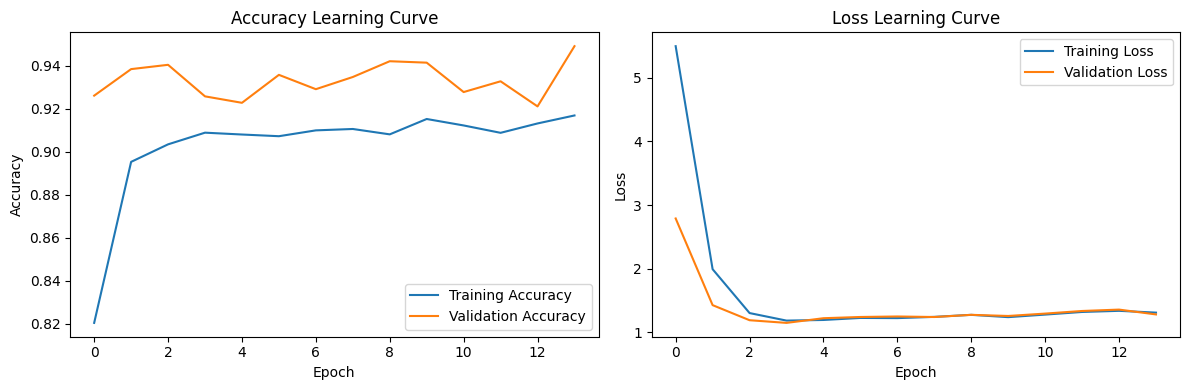

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficentNet_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

188/188 [==============================] - 99s 526ms/step - loss: 1.1386 - accuracy: 0.9400
Test Accuracy: 94.00%


In [8]:
predictions = efficentNet_model.predict(test_gen)
true_labels = test_gen.classes
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

188/188 [==============================] - 112s 567ms/step
Confusion Matrix:
[[713  29   6   2]
 [ 41 688  20   1]
 [ 18  35 676  21]
 [  0   1   7 742]]

Classification Report:
              precision    recall  f1-score   support

  all_benign       0.92      0.95      0.94       750
   all_early       0.91      0.92      0.92       750
     all_pre       0.95      0.90      0.93       750
     all_pro       0.97      0.99      0.98       750

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



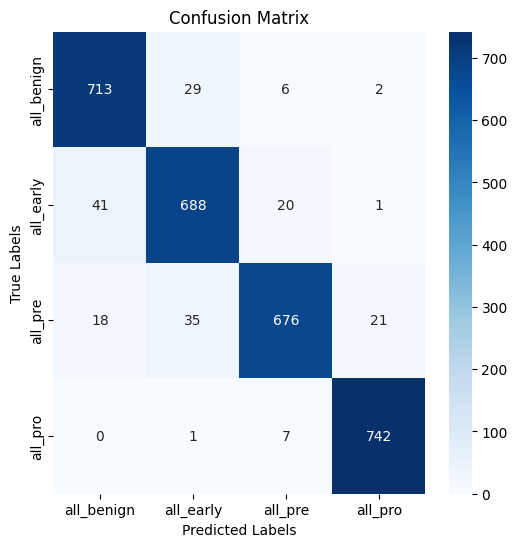

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)

188/188 [==============================] - 92s 488ms/step


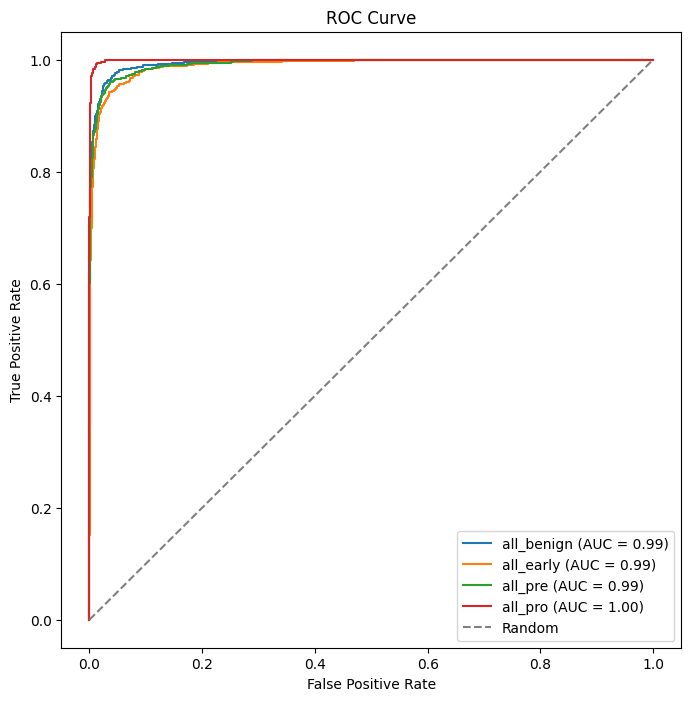

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_prob = efficentNet_model.predict(test_gen)
y_true = test_gen.classes

y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plot_roc_curve(y_true_one_hot, y_prob, class_names)